2024-03-05 12:55:00.483824: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 12:55:00.483986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 12:55:00.698235: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0349
Epoch 1: val_loss improved from inf to 0.04236, saving model to best_model.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - loss: 0.0346 - val_loss: 0.0424
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0016
Epoch 2: val_loss improved from 0.04236 to 0.02423, saving model to best_model.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 0.0016 - val_loss: 0.0242
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 6.7655e-04
Epoch 3: val_loss improved from 0.02423 to 0.01039, saving model to best_model.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 6.7920e-04 - val_loss: 0.0104
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 3.1722e-04
Epoch 4: val_loss improved from 0.01039 to 0.00555, saving model to best_model.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 3.1720e-04 - val_loss: 0.0055
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 3.1651e-04
Epoch 5: val

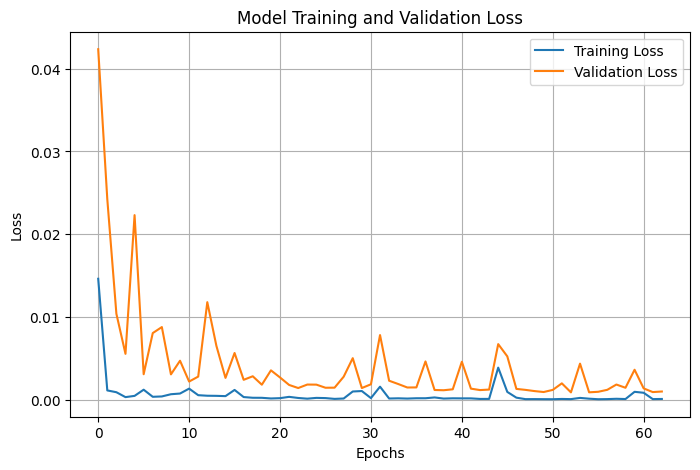

86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test RMSE: 2.7975465981154573
Test MAPE: 0.013757503836437222


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
import random

class TimeSeriesModel:
    """
    A class to encapsulate the process of loading, preprocessing, modeling, training, 
    and evaluating a time series model using LSTM neural networks.

    Attributes:
        filepath (str): The path to the CSV file to be read.
        column_name (str|int, optional): The name or index of the column to be selected for analysis.
        time_steps (int): The number of time steps to look back for the LSTM model.
        batch_size (int): Batch size for the generators.
        epochs (int): The number of epochs to train the model.
        model_path (str): The file path to save the best model during training.
    """
    def __init__(self, filepath, column_index=1, time_steps=60, batch_size=64, epochs=100, model_path='best_model.keras'):
        """
        Initializes the TimeSeriesModel with the specified parameters, including setting the random seed for reproducibility.
        Note that column_index=1 is the default, assuming the first column (index 0) is a datetime index and the second column (index 1) is the target variable.
        """
        self.filepath = filepath
        self.column_index = column_index  # This is the change
        self.time_steps = time_steps
        self.batch_size = batch_size
        self.epochs = epochs
        self.model_path = model_path
        np.random.seed(66)
        random.seed(66)
        tf.random.set_seed(66)
    
    def load_and_preprocess_data(self):
        """
        Load and preprocess time series data from a CSV file, including handling exceptions for file reading and data processing.
        """
        try:
            data = pd.read_csv(self.filepath, index_col=0, parse_dates=True)
        except FileNotFoundError:
            raise FileNotFoundError(f"The file at {self.filepath} was not found.")
        except Exception as e:
            raise Exception(f"An error occurred while reading the file: {e}")
        
        try:
            data.index = pd.to_datetime(data.index, utc=True).tz_localize(None)
            data = data.iloc[:, self.column_index-1:self.column_index]
        except IndexError:
            raise IndexError(f"Column index {self.column_index} is out of bounds for the dataset.")
        except Exception as e:
            raise Exception(f"An error occurred while processing the data: {e}")
        
        return data


    def split_data(self, data):
        """
        Split the dataset into training, validation, and testing sets based on specified years.
        """
        train_data = data[data.index.year <= 2020]
        valid_data = data[(data.index.year >= 2021) & (data.index.year <= 2022)]
        test_data = data[data.index.year >= 2023]
        return train_data, valid_data, test_data

    def scale_data(self, train_data, valid_data, test_data):
        """
        Scale the data using MinMaxScaler.
        """
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_train = self.scaler.fit_transform(train_data)
        scaled_valid = self.scaler.transform(valid_data)
        scaled_test = self.scaler.transform(test_data)
        return scaled_train, scaled_valid, scaled_test

    def create_generators(self, scaled_train, scaled_valid, scaled_test):
        """
        Create TimeseriesGenerators for training, validation, and testing datasets.
        """
        train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=self.time_steps, batch_size=self.batch_size)
        valid_generator = TimeseriesGenerator(scaled_valid, scaled_valid, length=self.time_steps, batch_size=self.batch_size)
        test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=self.time_steps, batch_size=self.batch_size)
        return train_generator, valid_generator, test_generator

    def define_model(self):
        """
        Define the LSTM model architecture.
        """
        model = Sequential([
            LSTM(128, input_shape=(self.time_steps, 1), return_sequences=True),
            LSTM(64, return_sequences=False),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    def train_model(self, model, train_generator, valid_generator):
        """
        Train the LSTM model with early stopping and model checkpoint callbacks.
        """
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, verbose=1),
            ModelCheckpoint(self.model_path, monitor='val_loss', save_best_only=True, verbose=1)
        ]
        history = model.fit(train_generator, validation_data=valid_generator, epochs=self.epochs, callbacks=callbacks)
        return history

    def evaluate_model(self, model, train_generator, valid_generator, test_generator):
        """
        Evaluate the trained model on training, validation, and test datasets.
        """
        def predict_and_inverse(generator):
            predictions = model.predict(generator)
            predictions_inverse = self.scaler.inverse_transform(predictions)  # Use self.scaler
            actuals = np.concatenate([y for _, y in generator], axis=0)
            actuals_inverse = self.scaler.inverse_transform(actuals)
            return predictions_inverse, actuals_inverse

        train_predictions_inverse, train_actuals_inverse = predict_and_inverse(train_generator)
        valid_predictions_inverse, valid_actuals_inverse = predict_and_inverse(valid_generator)
        test_predictions_inverse, test_actuals_inverse = predict_and_inverse(test_generator)

        test_rmse = math.sqrt(mean_squared_error(test_actuals_inverse, test_predictions_inverse))
        test_mape = mean_absolute_percentage_error(test_actuals_inverse, test_predictions_inverse)

        print(f"Test RMSE: {test_rmse}")
        print(f"Test MAPE: {test_mape}")

        return {
            'train': (train_predictions_inverse, train_actuals_inverse),
            'valid': (valid_predictions_inverse, valid_actuals_inverse),
            'test': (test_predictions_inverse, test_actuals_inverse)
        }
    
    def generate_date_ranges(self, actual, predictions_inverse, time_steps, freq='D'):
        """
        Generate date ranges for datasets based on the actual data index and the length of predictions.

        Parameters:
        - actual: DataFrame of the actual dataset.
        - predictions_inverse: Inverse transformed predictions for the dataset.
        - time_steps: Number of time steps used in the TimeseriesGenerator.
        - freq: Frequency of the dataset, default is 'D' for daily.

        Returns:
        A Pandas DatetimeIndex representing the date range for the dataset.
        """
        return pd.date_range(start=actual.index[time_steps], periods=len(predictions_inverse), freq=freq)

    def plot_results(self, predictions, actuals, dates, title='Actual vs Predicted Values'):
        """
        Plot the actual vs predicted values using Plotly.

        Parameters:
        - predictions: Inverse transformed predictions.
        - actuals: Actual values.
        - dates: Date range for plotting.
        - title: Title for the plot.
        """
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=dates, y=actuals.flatten(), mode='lines', name='Actual Value'))
        fig.add_trace(go.Scatter(x=dates, y=predictions.flatten(), mode='lines', name='Predicted Value'))
        fig.update_layout(title=title, xaxis_title='Date', yaxis_title='Value', xaxis_rangeslider_visible=True)
        fig.show()

    def plot_training_history(self, history):
        """
        Plot the training and validation loss over epochs.

        Parameters:
        - history: A History object returned by the fit method of models.
        """
        plt.figure(figsize=(8, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
    

    def run(self):
        """
        Executes the complete workflow for training and evaluating the time series model.
        """
        data = self.load_and_preprocess_data()
        train_data, valid_data, test_data = self.split_data(data)
        scaled_train, scaled_valid, scaled_test = self.scale_data(train_data, valid_data, test_data)
        train_generator, valid_generator, test_generator = self.create_generators(scaled_train, scaled_valid, scaled_test)
        model = self.define_model()
        history = self.train_model(model, train_generator, valid_generator)
        self.plot_training_history(history)  # Use self to call the method
        
        best_model = tf.keras.models.load_model(self.model_path)  # Use self.model_path
        results = self.evaluate_model(best_model, train_generator, valid_generator, test_generator)  # Use self to call the method
        
        # Generate date ranges for plotting
        train_dates = self.generate_date_ranges(train_data, results['train'][0], self.time_steps, freq='D')  # Use self to call the method
        valid_dates = self.generate_date_ranges(valid_data, results['valid'][0], self.time_steps, freq='D')  # Use self to call the method
        test_dates = self.generate_date_ranges(test_data, results['test'][0], self.time_steps, freq='D')  # Use self to call the method
        
        # Plotting results
        self.plot_results(results['train'][0], results['train'][1], train_dates, "Train Set: Actual vs Predicted Values")  # Use self to call the method
        self.plot_results(results['valid'][0], results['valid'][1], valid_dates, "Validation Set: Actual vs Predicted Values")  # Use self to call the method
        self.plot_results(results['test'][0], results['test'][1], test_dates, "Test Set: Actual vs Predicted Values")  # Use self to call the method

# Example usage
if __name__ == "__main__":
    ts_model = TimeSeriesModel(filepath="/kaggle/input/master-data-csv/master_data.csv", column_index=1)
    ts_model.run()
